# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [1]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.668161434978


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [125]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [126]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.57399103139


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [127]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [128]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [129]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [130]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [131]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.values.reshape(1,-1)).T

In [132]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived

# TASK : split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.67264573991


## Part 2: Confusion Matrix

In [133]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [4]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

Confusion matrix, without normalization
[[105  23]
 [ 51  44]]


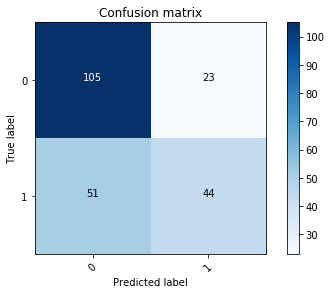

In [3]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [136]:
# calculate the sensitivity
43 / float(52 + 43)

0.45263157894736844

In [137]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [138]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

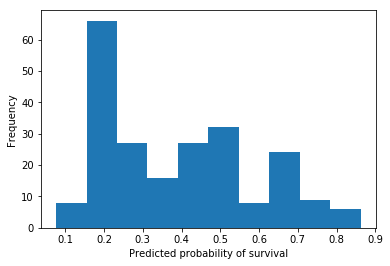

In [139]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [140]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [141]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.25).T

In [142]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[57 71]
 [27 68]]


In [143]:
# new sensitivity
print (68 / float(27 + 68))

0.7157894736842105


In [144]:
# new specificity
print (57 / float(57 + 71))

0.4453125


## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [145]:
from sklearn import cross_validation
bikeshare = pd.read_csv('bikeshare.csv')
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Create dummy variables and set outcome (dependent) variable

In [146]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual

#### Create a cross validation with 5 folds

In [147]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [148]:
from sklearn import linear_model
mse_values = []
scores = []
n= 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1542.32378815
R2: 0.311917510445
Model 2
MSE: 1796.08708828
R2: 0.311910112677
Model 3
MSE: 1651.67528972
R2: 0.311908984867
Model 4
MSE: 1533.288308
R2: 0.311919021633
Model 5
MSE: 1843.75730724
R2: 0.311826299545
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.42635628
Mean of R2 for all folds: 0.311896385833


In [149]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 1672.58110765
R2:  0.311934605989


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


### Answer: 

The cross-validated approach generates more error - the MSE is higher in the cross-validated approach - the CV approach will predict data more accurately as it has a lower average R2 as in this model. A lower R2 means the proportion of the variance of X predictable from Y is lower in CV than in single linear. As such, Y can be correctly predicted more often from X in the CV model than the single linear model.

----

#### Explanation of R2 and MSE: 

MSE - or Means Squared Error - is the degree of deviance between the model predicted and known points in the model. That is, the linear model has a better fit to the known points, as there's less difference between it and the known points. 
However, R2 - Coefficient of Determination - is the inverse percentage of the sum of squared error (the difference between the model predicted and known points) divided by the sum of squared deviations from the dependent's Y mean (that is, a straight line running parallel to X). It indicates the proportion of the variance in the dependent variable that is predictable from the independent variable(s); i.e. it measures how related the two variables are - an R2 of 0 means Y cannot be predicted from X, an R2 of 1 means Y can always be correctly predicted from X.


The better the linear regression (on the right) fits the data in comparison to the simple average (on the left graph), the closer the value of R2 is to 1. The areas of the blue squares represent the squared residuals with respect to the linear regression. The areas of the red squares represent the squared residuals with respect to the average value:

![MSEvR2](https://upload.wikimedia.org/wikipedia/commons/8/86/Coefficient_of_Determination.svg)

* https://stats.stackexchange.com/questions/32596/what-is-the-difference-between-coefficient-of-determination-and-mean-squared
* https://en.wikipedia.org/wiki/Coefficient_of_determination
* http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination

## Part 4: Apply Cross Validation to the Titanic Dataset

In [150]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [151]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [152]:
# Convert character vectors - sex, embarked, pclass
titanicwd = pd.get_dummies(data=titanic, columns = ['Sex', 'Embarked', 'Pclass'], prefix = ['Sex', 'Embarked', 'Pclass'] )
# Fill any null values of age by taking average by gender, class and parch
titanicwd['Age']=titanicwd[["Age","Parch","Sex_male","Pclass_1","Pclass_2"]].groupby(["Parch","Sex_male",'Pclass_1', 'Pclass_2'])['Age'].transform(lambda x: x.fillna(x.mean()))

titanicwd.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [154]:
feature_cols = ['Sex_male', 'Sex_female','Embarked_C','Embarked_Q','Embarked_S','Pclass_1', 'Pclass_2', 'Pclass_3','Parch', 'Age','SibSp']
X = titanicwd[feature_cols]
y = titanicwd.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])
y_pred_class = logreg.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_class))

0.811659192825


In [155]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)

[ 0.8         0.78888889  0.78651685  0.84269663  0.82022472  0.78651685
  0.80898876  0.79775281  0.82022472  0.82954545]


In [156]:
print(scores.mean())

0.808135569175


### Task: Evaluate each stage of the model with Cross-Validation

In [157]:
from sklearn import cross_validation
from sklearn import linear_model
mse_values = []
scores = []
n = 0

feature_cols = ['Sex_male', 'Sex_female','Embarked_C','Embarked_Q','Embarked_S','Pclass_1', 'Pclass_2', 'Pclass_3',]
modeldata = titanicwd[feature_cols]
y = titanicwd.Survived 

kf = cross_validation.KFold(len(modeldata), n_folds=10, shuffle=True)

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.144609508107
R2: 0.373308051275
Model 2
MSE: 0.155232847407
R2: 0.373158381662
Model 3
MSE: 0.142766405485
R2: 0.372148956765
Model 4
MSE: 0.176711979304
R2: 0.372955678814
Model 5
MSE: 0.12397337792
R2: 0.372849425708
Model 6
MSE: 0.169605726606
R2: 0.369831733605
Model 7
MSE: 0.153020706894
R2: 0.373372529568
Model 8
MSE: 0.142538499139
R2: 0.37335622167
Model 9
MSE: 0.137936571762
R2: 0.37277278536
Model 10
MSE: 0.156133334171
R2: 0.373142680505
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.150252895679
Mean of R2 for all folds: 0.372689644493


### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

In [159]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
print ("2 FOLDS")
print ('Mean of MSE for 2 folds:', np.mean(mse_values))
print ('Mean of R2 for ) folds:', np.mean(scores))

kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
print ("5 FOLDS")
print ('Mean of MSE for 5 folds:', np.mean(mse_values))
print ('Mean of R2 for 5 folds:', np.mean(scores))

kf = cross_validation.KFold(len(modeldata), n_folds=10, shuffle=True)
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
print ("10 FOLDS")
print ('Mean of MSE for 10 folds:', np.mean(mse_values))
print ('Mean of R2 for 10 folds:', np.mean(scores))

kf = cross_validation.KFold(len(modeldata), n_folds=50, shuffle=True)
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
print ("50 FOLDS")
print ('Mean of MSE for 50 folds:', np.mean(mse_values))
print ('Mean of R2 for 50 folds:', np.mean(scores))

kf = cross_validation.KFold(len(modeldata), n_folds=100, shuffle=True)
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
print ("100 FOLDS")
print ('Mean of MSE for 100 folds:', np.mean(mse_values))
print ('Mean of R2 for 100 folds:', np.mean(scores))

2 FOLDS
Mean of MSE for 2 folds: 0.150261192425
Mean of R2 for ) folds: 0.373038697015
5 FOLDS
Mean of MSE for 5 folds: 0.150295253033
Mean of R2 for 5 folds: 0.372992336796
10 FOLDS
Mean of MSE for 10 folds: 0.15034366188
Mean of R2 for 10 folds: 0.372967118069
50 FOLDS
Mean of MSE for 50 folds: 0.150343248489
Mean of R2 for 50 folds: 0.373073492577
100 FOLDS
Mean of MSE for 100 folds: 0.15044124047
Mean of R2 for 100 folds: 0.373156436314


### Task: Experiment with different model evaluation metrics from sci-kit learn

See a list of model evaluation metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html



In [184]:
print('MSE mean for 100 folds:',np.mean(mse_values))
print('R2 mean for 100 folds:',np.mean(scores))


#Accuracy score returns the percent of true positives and true negatives samples (in decimal format with 1 being perfect)
print('Accuracy score:',metrics.accuracy_score(y_test, y_pred_class))
#Precision score returns the correctly identified 
# = # true positives / true positives + false positives:
print('Precision score:',metrics.precision_score(y_test, y_pred_class))
#Recall score returns the # of  positives correctly predicted 
# = # true positives / true positives + false negatives:
print('Recall score:',metrics.recall_score(y_test,y_pred_class))
# The F1 score can be interpreted as a weighted average of the precision and recall.
# An F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal. 
# F1 = 2 * (precision * recall) / (precision + recall)
print('F1 score:',metrics.f1_score(y_test,y_pred_class))

MSE mean for 100 folds: 0.15044124047
R2 mean for 100 folds: 0.373156436314
Accuracy score: 0.811659192825
Precision score: 0.827160493827
Recall score: 0.705263157895
F1 score: 0.761363636364
